In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
sys.path.append('../../context-tree-weighting/')

from ctw import CTW

# Markov Process Simulation

This notebook explores the measurement of causal influence between two discrete jointly Markov random processes, $\{X_i\}_{i=1}^n$ and $\{Y_i\}_{i=1}^n$. We'll look at the following three scenarios: 

1. $X$ and $Y$ independent
2. Unidirectional influence ($Y\rightarrow X$ and $X\not\rightarrow Y$)
3. Bidirectional influence ($Y\rightarrow X$ and $X\rightarrow Y$)*

## Process Generation
First, we'll define 4 state transition matrices. First, for the independent case, we define the probabilities of transitioning from $x_i$ to $x_{i+1}$ and $y_i$ to $y_{i+1}$. In the unidirectional case, we can reuse the transition matrix for independent $Y$ and define probabilities for transitioning from $(x_i,y_i)$ to $(x_{i+1},\cdot)$. Lastly, for the bidirectional case, we define the probabilities of transitioning from $(x_i,y_i)$ to $(\cdot,y_{i+1})$ to use with the matrix from $(x_i,y_i)$ to $(x_{i+1},\cdot)$.

In [65]:
x2x = {
    '0':[3/9,5/9,1/9],
    '1' :[1/9,6/9,2/9],
    '2' :[1/9,4/9,4/9] }

y2y = {
    '0':[3/9,5/9,1/9],
    '1' :[1/9,7/9,1/9],
    '2' :[1/9,5/9,3/9] }

xy2x = {
    '(0,0)':[5/9,3/9,1/9],
    '(1,0)' :[3/9,5/9,1/9],
    '(2,0)' :[2/9,5/9,2/9],
    '(0,1)':[5/9,3/9,1/9],
    '(1,1)' :[1/9,7/9,1/9],
    '(2,1)' :[1/9,5/9,3/9],
    '(0,2)':[3/9,5/9,1/9],
    '(1,2)' :[1/9,6/9,2/9],
    '(2,2)' :[1/9,4/9,4/9] }

xy2y = {
    '(0,0)':[5/9,3/9,1/9],
    '(1,0)' :[7/9,1/9,1/9],
    '(2,0)' :[2/9,6/9,1/9],
    '(0,1)':[3/9,5/9,1/9],
    '(1,1)' :[3/9,5/9,1/9],
    '(2,1)' :[1/9,5/9,3/9],
    '(0,2)':[6/9,2/9,1/9],
    '(1,2)' :[1/9,5/9,3/9],
    '(2,2)' :[1/9,4/9,4/9] }

Using these probabilities, we define 3 functions for sampling the next state $(x_{i+1},y_{i+1})$ given a previous state $(x_i,y_i)$ and another function to generate $n$ samples using one of the models.

In [66]:
def indpedent_sample(x_,y_):
    x = np.argmax(np.random.multinomial(1,x2x[str(x_)]))
    y = np.argmax(np.random.multinomial(1,y2y[str(y_)]))
    return x,y

def unidirectional_sample(x_,y_):
    x = np.argmax(np.random.multinomial(1,xy2x['(%i,%i)'%(x_,y_)]))
    y = np.argmax(np.random.multinomial(1,y2y[str(y_)]))
    return x,y

def bidirectional_sample(x_,y_):
    x = np.argmax(np.random.multinomial(1,xy2x['(%i,%i)'%(x_,y_)]))
    y = np.argmax(np.random.multinomial(1,xy2y['(%i,%i)'%(x_,y_)]))
    return x,y

In [67]:
def gen_seqs(n=500,mode='indep'):
    if mode == 'indep':
        sampler = indpedent_sample
    elif mode == 'unidir':
        sampler = unidirectional_sample
    elif mode == 'bidir':
        sampler = bidirectional_sample
    else:
        raise TypeError("mode must be 'indep', 'unidir' or 'bidir'")
    x = 1
    y = 1
    xs = []
    ys = []
    for i in range(n):
        x,y = sampler(x,y)
        xs.append(x)
        ys.append(y)
    return xs,ys

## True Causal Measure

In [68]:
def kl(p,q):
    tot = 0
    for x in range(len(p)):
         tot += p[x]*np.log2(p[x]/q[x])
    return tot

def unidirectional_measure(xs,ys):
    cyx = []
    ymat = np.asarray([y2y[str(i)] for i in range(3)])
    yprobs = np.asarray([1/3,1/3,1/3])
    for i,(x,y) in enumerate(zip(xs,ys)):
        fc = xy2x['(%i,%i)'%(x,y)]
        yprobs = np.dot(ymat.T,yprobs)
        xmat = np.asarray([xy2x['(%i,%i)'%(x,i)] for i in range(3)])
        fr = np.dot(xmat.T,yprobs)
        cyx.append(kl(fc,fr))
    return cyx

def bidirectional_measure(xs,ys):
    cyx = []
    cxy = []
    xprobs = np.asarray([1/3,1/3,1/3])
    yprobs = np.asarray([1/3,1/3,1/3])
    for i,(x,y) in enumerate(zip(xs,ys)):
        # get the complete distribution for x and y
        fcx = xy2x['(%i,%i)'%(x,y)]
        fcy = xy2y['(%i,%i)'%(x,y)]
        # matrices for updating probabilities of hidden x and y
        xmat = np.asarray([xy2x['(%i,%i)'%(i,y)] for i in range(3)])
        ymat = np.asarray([xy2y['(%i,%i)'%(x,i)] for i in range(3)])
        # update hidden probabilities
        xprobs = np.dot(xmat.T,xprobs)
        yprobs = np.dot(ymat.T,yprobs)
        # matrices for computing restricted distributions from hidden probabilities
        xmat = np.asarray([xy2x['(%i,%i)'%(x,i)] for i in range(3)])
        ymat = np.asarray([xy2y['(%i,%i)'%(i,y)] for i in range(3)])
        # get the restricted distributions
        frx = np.dot(xmat.T,yprobs)
        fry = np.dot(ymat.T,xprobs)
        # update causal measures
        cyx.append(kl(fcx,frx))
        cxy.append(kl(fcy,fry))
    return cyx,cxy

## Partial Causal Measure

In [69]:
def unidirectional_partial_measure(xs,ys,k):
    cyx = []
    for i,(x,y) in enumerate(zip(xs[k:],ys[k:])):
        fc = xy2x['(%i,%i)'%(x,y)]
        yprobs = np.asarray([0,0,0])
        yprobs[ys[i]] = 1
        for l in range(k):
            ymat =  np.asarray([y2y['%i'%(j)] for j in range(3)])
            yprobs = np.dot(ymat.T,yprobs)
        xmat = np.asarray([xy2x['(%i,%i)'%(x,j)] for j in range(3)])
        fr = np.dot(xmat.T,yprobs)
        cyx.append(kl(fc,fr))
    return cyx

def bidirectional_partial_measure(xs,ys,k):
    cyx = []
    cxy = []
    for i,(x,y) in enumerate(zip(xs[k:],ys[k:])):
        fcx = xy2x['(%i,%i)'%(x,y)]
        fcy = xy2y['(%i,%i)'%(x,y)]
        xprobs = np.asarray([0,0,0])
        xprobs[xs[i]] = 1
        yprobs = np.asarray([0,0,0])
        yprobs[ys[i]] = 1
        for l in range(k):
            xmat =  np.asarray([xy2x['(%i,%i)'%(j,ys[i+l])] for j in range(3)])
            ymat =  np.asarray([xy2y['(%i,%i)'%(xs[i+l],j)] for j in range(3)])
            xprobs = np.dot(xmat.T,xprobs)
            yprobs = np.dot(ymat.T,yprobs)
        xmat = np.asarray([xy2x['(%i,%i)'%(x,j)] for j in range(3)])
        frx = np.dot(xmat.T,yprobs)
        cyx.append(kl(fcx,frx))
        ymat = np.asarray([xy2y['(%i,%i)'%(j,y)] for j in range(3)])
        fry = np.dot(ymat.T,xprobs)
        cxy.append(kl(fcy,fry))
    return cyx,cxy

## Independent Processes

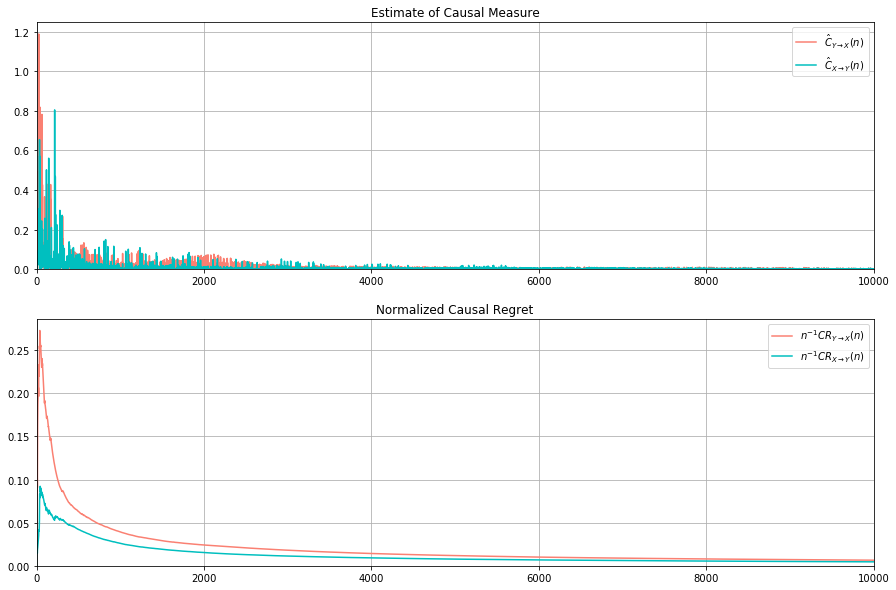

In [74]:
x,y = gen_seqs(n=10000,mode='indep')

ctwxc = CTW(depth=1,symbols=3,sidesymbols=3)
pxcs = ctwxc.predict_sequence(x,sideseq=y)

ctwxr = CTW(depth=1,symbols=3)
pxrs = ctwxr.predict_sequence(x)

cyx = [kl(pxcs[:,i],pxrs[:,i]) for i in range(pxcs.shape[1])]

ctwyc = CTW(depth=1,symbols=3,sidesymbols=3)
pycs = ctwyc.predict_sequence(y,sideseq=x)

ctwyr = CTW(depth=1,symbols=3)
pyrs = ctwyr.predict_sequence(y)

cxy = [kl(pycs[:,i],pyrs[:,i]) for i in range(pycs.shape[1])]

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(15,10))
ax1.plot(cyx,c='salmon',label=r'$\hat{C}_{Y\rightarrow X}(n)$')
ax1.plot(cxy,c='c',label=r'$\hat{C}_{X\rightarrow Y}(n)$')
ax1.set_xlim([0,n])
ax1.set_ylim([0,ax1.get_ylim()[1]])
ax1.legend()
ax1.set_title('Estimate of Causal Measure')
ax1.grid('on')
ax2.plot(np.cumsum(cyx)/np.arange(1,len(cyx)+1),c='salmon',label=r'$n^{-1}CR_{Y\rightarrow X}(n)$')
ax2.plot(np.cumsum(cxy)/np.arange(1,len(cxy)+1),c='c',label=r'$n^{-1}CR_{X\rightarrow Y}(n)$')
ax2.legend()
ax2.set_title('Normalized Causal Regret')
ax2.set_xlim([0,n])
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.grid('on');

## Unidirectional Influence

### Complete Causal Measure

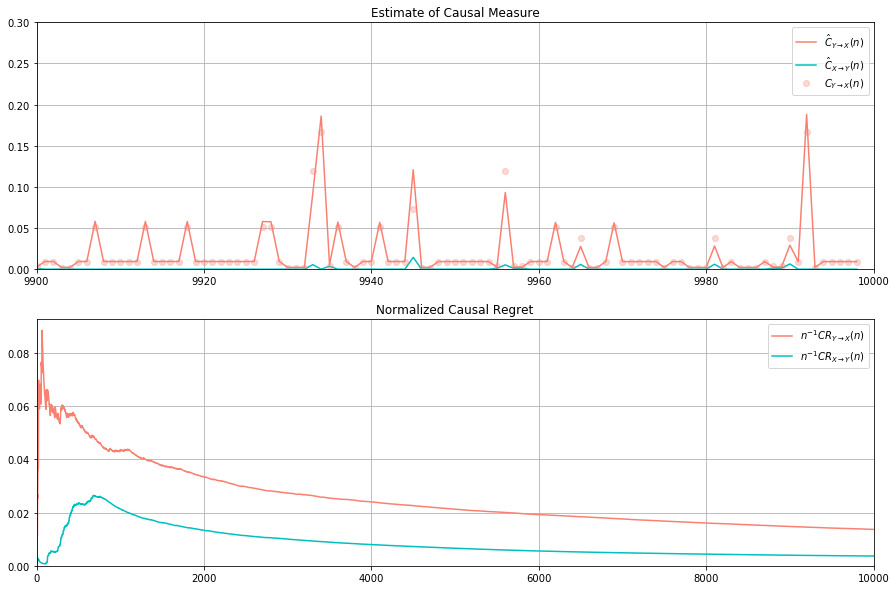

In [80]:
d = 1
n = 10000

x,y = gen_seqs(n=n,mode='unidir')

true_cyx = unidirectional_measure(x,y)

ctwxc = CTW(depth=1,symbols=3,sidesymbols=3)
pxcs = ctwxc.predict_sequence(x,sideseq=y)

ctwxr = CTW(depth=d,symbols=3)
pxrs = ctwxr.predict_sequence(x)

cyx = [kl(pxcs[:,i+d-1],pxrs[:,i]) for i in range(pxcs.shape[1])]

ctwyc = CTW(depth=1,symbols=3,sidesymbols=3)
pycs = ctwyc.predict_sequence(y,sideseq=x)

ctwyr = CTW(depth=d,symbols=3)
pyrs = ctwyr.predict_sequence(y)

cxy = [kl(pycs[:,i+d-1],pyrs[:,i]) for i in range(pycs.shape[1])]

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(15,10))
ax1.plot(cyx,c='salmon',label=r'$\hat{C}_{Y\rightarrow X}(n)$')
ax1.plot(cxy,c='c',label=r'$\hat{C}_{X\rightarrow Y}(n)$')
ax1.plot(true_cyx[d-1:-1],'o',alpha=0.3,c='salmon',label=r'$C_{Y\rightarrow X}(n)$')
ax1.set_xlim([n-100,n])
ax1.set_ylim([0,0.3])
ax1.legend()
ax1.set_title('Estimate of Causal Measure')
ax1.grid('on')
ax2.plot(np.cumsum(np.abs(np.asarray(cyx)-np.asarray(true_cyx[d-1:-1])))/np.arange(1,len(cyx)+1),
         c='salmon',label=r'$n^{-1}CR_{Y\rightarrow X}(n)$')
ax2.plot(np.cumsum(cxy)/np.arange(1,len(cxy)+1),c='c',label=r'$n^{-1}CR_{X\rightarrow Y}(n)$')
ax2.legend()
ax2.set_title('Normalized Causal Regret')
ax2.set_xlim([0,n])
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.grid('on');

### Partial Causal Measure

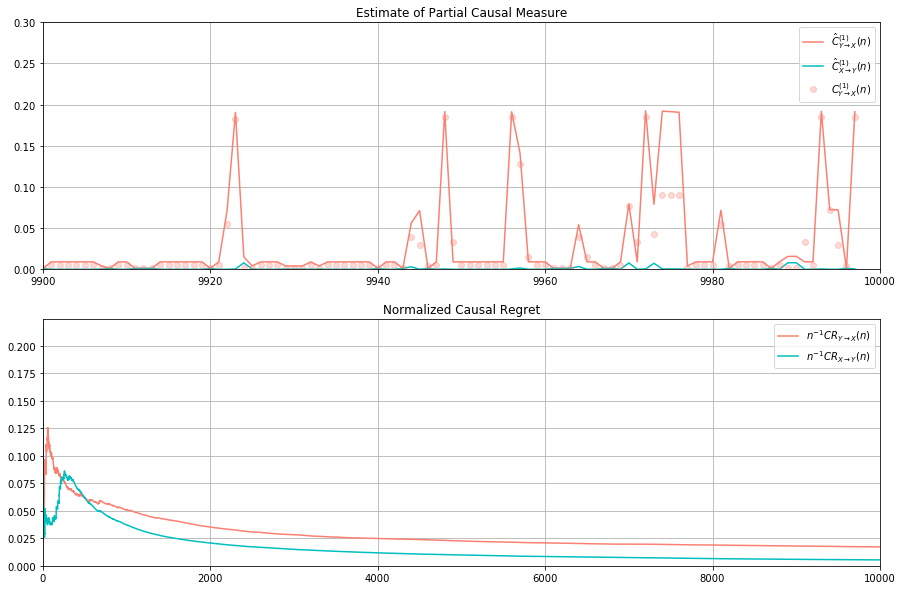

In [89]:
d = 2
n = 10000

x,y = gen_seqs(n=n,mode='unidir')

true_cyx = unidirectional_partial_measure(x,y,k=d-1)

ctwxc = CTW(depth=1,symbols=3,sidesymbols=3)
pxcs = ctwxc.predict_sequence(x,sideseq=y)

ctwxr = CTW(depth=d,symbols=3,sidesymbols=3,staleness=d-1)
pxrs = ctwxr.predict_sequence(x,sideseq=y)

cyx = [kl(pxcs[:,i+d-1],pxrs[:,i]) for i in range(pxrs.shape[1])]

ctwyc = CTW(depth=1,symbols=3,sidesymbols=3)
pycs = ctwyc.predict_sequence(y,sideseq=x)

ctwyr = CTW(depth=d,symbols=3,sidesymbols=3,staleness=d-1)
pyrs = ctwyr.predict_sequence(y,sideseq=x)

cxy = [kl(pycs[:,i+d-1],pyrs[:,i]) for i in range(pyrs.shape[1])]

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(15,10))
ax1.plot(cyx,c='salmon',label=r'$\hat{C}^{(%i)}_{Y\rightarrow X}(n)$'%(d-1))
ax1.plot(cxy,c='c',label=r'$\hat{C}^{(%i)}_{X\rightarrow Y}(n)$'%(d-1))
ax1.plot(true_cyx[:-1],'o',alpha=0.3,c='salmon',label=r'$C^{(%i)}_{Y\rightarrow X}(n)$'%(d-1))
ax1.set_xlim([n-100,n])
ax1.set_ylim([0,0.3])
ax1.legend()
ax1.set_title('Estimate of Partial Causal Measure')
ax1.grid('on')
ax2.plot(np.cumsum(np.abs(np.asarray(cyx)-np.asarray(true_cyx[:-1])))/np.arange(1,len(cyx)+1),
         c='salmon',label=r'$n^{-1}CR_{Y\rightarrow X}(n)$')
ax2.plot(np.cumsum(cxy)/np.arange(1,len(cxy)+1),c='c',label=r'$n^{-1}CR_{X\rightarrow Y}(n)$')
ax2.legend()
ax2.set_title('Normalized Causal Regret')
ax2.set_xlim([0,n])
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.grid('on');

## Bidirectional Influence

### Complete Causal Measure

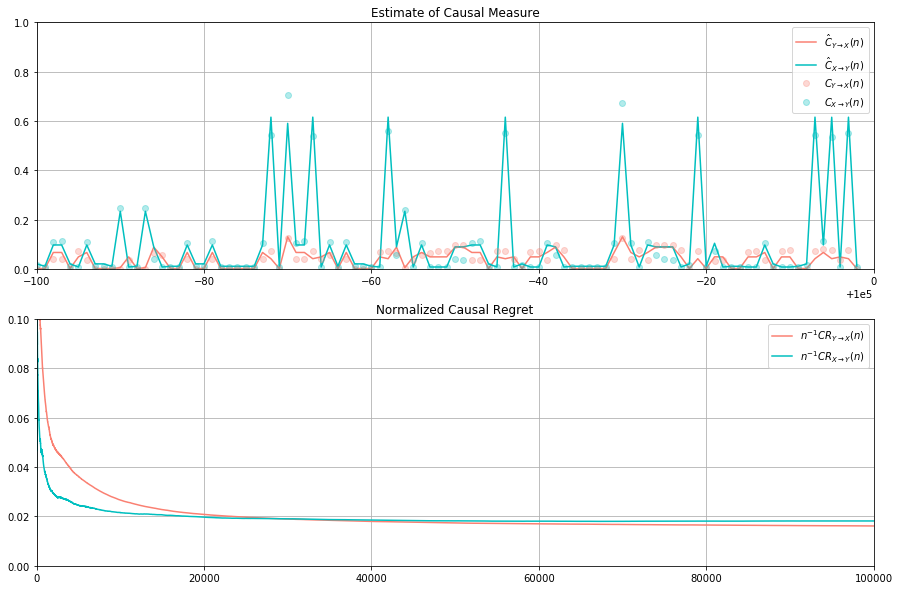

In [87]:
d = 1
n = 100000
x,y = gen_seqs(n=n,mode='bidir')

true_cyx, true_cxy = bidirectional_measure(x,y)

ctwxc = CTW(depth=1,symbols=3,sidesymbols=3)
pxcs = ctwxc.predict_sequence(x,sideseq=y)

ctwxr = CTW(depth=d,symbols=3)
pxrs = ctwxr.predict_sequence(x)

cyx = [kl(pxcs[:,i+d-1],pxrs[:,i]) for i in range(pxrs.shape[1])]

ctwyc = CTW(depth=1,symbols=3,sidesymbols=3)
pycs = ctwyc.predict_sequence(y,sideseq=x)

ctwyr = CTW(depth=d,symbols=3)
pyrs = ctwyr.predict_sequence(y)

cxy = [kl(pycs[:,i+d-1],pyrs[:,i]) for i in range(pyrs.shape[1])]

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(15,10))
ax1.plot(cyx,c='salmon',label=r'$\hat{C}_{Y\rightarrow X}(n)$')
ax1.plot(cxy,c='c',label=r'$\hat{C}_{X\rightarrow Y}(n)$')
ax1.plot(true_cyx[d-1:-1],'o',alpha=0.3,c='salmon',label=r'$C_{Y\rightarrow X}(n)$')
ax1.plot(true_cxy[d-1:-1],'o',alpha=0.3,c='c',label=r'$C_{X\rightarrow Y}(n)$')
ax1.set_xlim([n-100,n])
ax1.set_ylim([0,1])
ax1.legend()
ax1.set_title('Estimate of Causal Measure')
ax1.grid('on')
ax2.plot(np.cumsum(np.abs(np.asarray(cyx)-np.asarray(true_cyx[d-1:-1])))/np.arange(1,len(cyx)+1),
         c='salmon',label=r'$n^{-1}CR_{Y\rightarrow X}(n)$')
ax2.plot(np.cumsum(np.abs(np.asarray(cxy)-np.asarray(true_cxy[d-1:-1])))/np.arange(1,len(cyx)+1),
         c='c',label=r'$n^{-1}CR_{X\rightarrow Y}(n)$')
ax2.legend()
ax2.set_title('Normalized Causal Regret')
ax2.set_xlim([0,n])
ax2.set_ylim([0,0.1])
ax2.grid('on');

### Partial Causal Measure

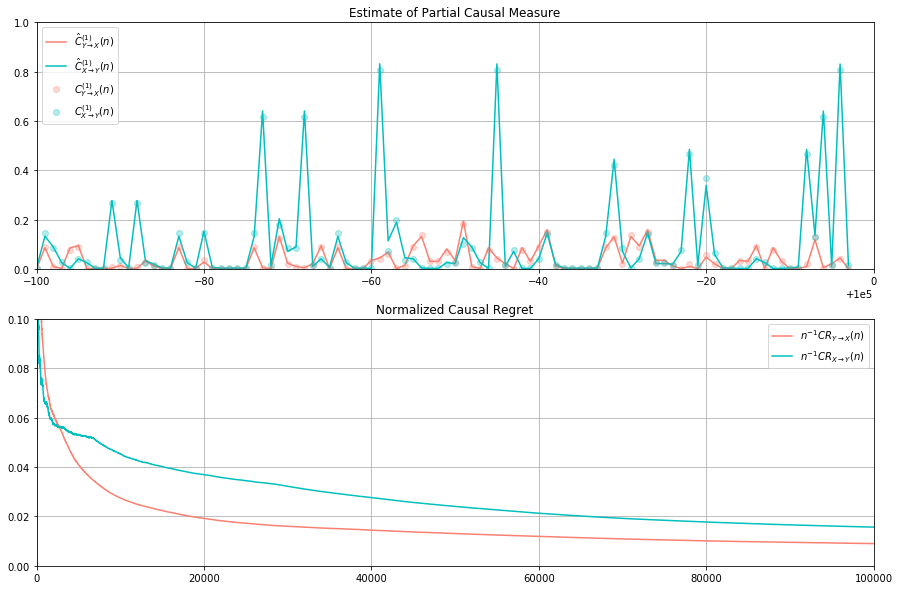

In [88]:
d = 2
#n = 100000
#x,y = gen_seqs(n=n,mode='bidir')

true_cyx,true_cxy = bidirectional_partial_measure(x,y,k=d-1)

ctwxc = CTW(depth=1,symbols=3,sidesymbols=3)
pxcs = ctwxc.predict_sequence(x,sideseq=y)

ctwxr = CTW(depth=d,symbols=3,sidesymbols=3,staleness=d-1)
pxrs = ctwxr.predict_sequence(x,sideseq=y)

cyx = [kl(pxcs[:,i+d-1],pxrs[:,i]) for i in range(pxrs.shape[1])]

ctwyc = CTW(depth=1,symbols=3,sidesymbols=3)
pycs = ctwyc.predict_sequence(y,sideseq=x)

ctwyr = CTW(depth=d,symbols=3,sidesymbols=3,staleness=d-1)
pyrs = ctwyr.predict_sequence(y,sideseq=x)

cxy = [kl(pycs[:,i+d-1],pyrs[:,i]) for i in range(pyrs.shape[1])]

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(15,10))
ax1.plot(cyx,c='salmon',label=r'$\hat{C}^{(%i)}_{Y\rightarrow X}(n)$'%(d-1))
ax1.plot(cxy,c='c',label=r'$\hat{C}^{(%i)}_{X\rightarrow Y}(n)$'%(d-1))
ax1.plot(true_cyx[:-1],'o',alpha=0.3,c='salmon',label=r'$C^{(%i)}_{Y\rightarrow X}(n)$'%(d-1))
ax1.plot(true_cxy[:-1],'o',alpha=0.3,c='c',label=r'$C^{(%i)}_{X\rightarrow Y}(n)$'%(d-1))
ax1.set_xlim([n-100,n])
ax1.set_ylim([0,1])
ax1.legend()
ax1.set_title('Estimate of Partial Causal Measure')
ax1.grid('on')
ax2.plot(np.cumsum(np.abs(np.asarray(cyx)-np.asarray(true_cyx[:-1])))/np.arange(1,len(cyx)+1),
         c='salmon',label=r'$n^{-1}CR_{Y\rightarrow X}(n)$')
ax2.plot(np.cumsum(np.abs(np.asarray(cxy)-np.asarray(true_cxy[:-1])))/np.arange(1,len(cyx)+1),
         c='c',label=r'$n^{-1}CR_{X\rightarrow Y}(n)$')
ax2.legend()
ax2.set_title('Normalized Causal Regret')
ax2.set_xlim([0,n])
ax2.set_ylim([0,0.1])
ax2.grid('on');